In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [19]:
def loss_function(x, x_hat, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [2]:
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
# Normalize pixels to [0, 1]
X = X / 255.0
# Convert to PyTorch tensor
X = torch.tensor(X, dtype=torch.float32)

In [21]:
# Hyperparameters
input_dim = 784
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 10

# Data loader
train_dataset = TensorDataset(X)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, optimizer
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Training loop
vae.train()
for epoch in range(epochs):
    train_loss = 0.0

    for (x,) in train_loader:
        optimizer.zero_grad()

        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 163.6632
Epoch 2, Loss: 120.9454
Epoch 3, Loss: 114.4338
Epoch 4, Loss: 111.4712
Epoch 5, Loss: 109.6711
Epoch 6, Loss: 108.4477
Epoch 7, Loss: 107.6344
Epoch 8, Loss: 107.0410
Epoch 9, Loss: 106.5225
Epoch 10, Loss: 106.0889


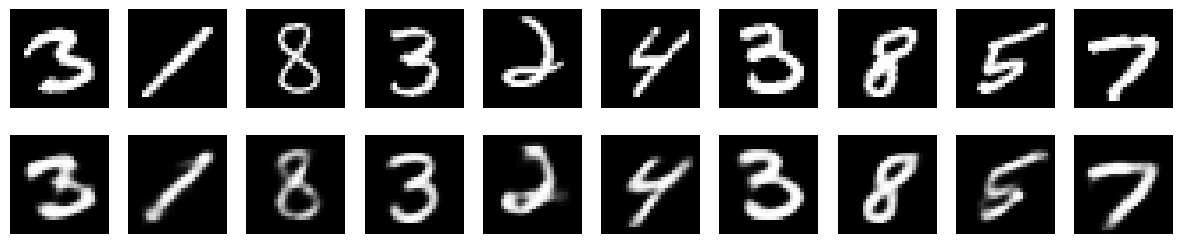

In [23]:
# Visualizing reconstructed outputs
vae.eval()
with torch.no_grad():
    (x,) = next(iter(train_loader))
    x = x.view(-1, input_dim)
    x_hat, _, _ = vae(x)
    x = x.view(-1, 28, 28)
    x_hat = x_hat.view(-1, 28, 28)

fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
    axs[1, i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

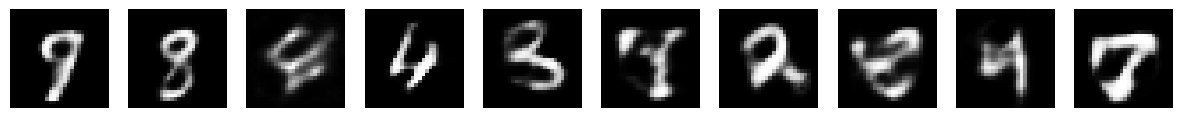

In [26]:
# Visualizing generated samples
with torch.no_grad():
    z = torch.randn(10, latent_dim)
    sample = vae.decoder(z)
    sample = sample.view(-1, 28, 28)

fig, axs = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axs[i].imshow(sample[i].cpu().numpy(), cmap='gray')
    axs[i].axis('off')
plt.show()